## Projeto Final Redes Neurais: Propriedades Mecânicas de Materiais

#### Trio: csv_Computeiros_sinápticos_virtuais 

#### Integrantes: Diogo Pereira de Lima Carvalho, José David Sales e Mayllon Emmanoel Pequeno

<p style="text-align: justify;"> O notebook em questão consiste nos processos que envolvem a criação de fato da rede neural e seu treinamento. Aqui, há a criação de um modelo com três camadas ocultas, a qual se estudou a curva de aprendizado, o RMSE e o gráfico relacionando o valor real do predito resultante da rede neural. Para isso, note que as classes <code>DataModule</code> e <code>MLP</code> foram importadas do arquivo <i>objetos_rede_neural.py</i>, sendo tais classes baseadas nas criadas anteriormente pelo professor Daniel Roberto Cassar [1]. 

Abaixo, importou-se as bibliotecas necessárias e determinou-se as constantes utilizadas nesde notebook.

In [12]:
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scipy import stats
from sklearn.metrics import root_mean_squared_error
from objetos_rede_neural import DataModule, MLP
from lightning.pytorch.loggers import TensorBoardLogger
import os

In [13]:
TAMANHO_TESTE = 0.1
TAMANHO_VALIDACAO = 0.1
SEMENTE_ALEATORIA = 0
NUM_EPOCAS = 5

<p style="text-align: justify;"> Abaixo, foi definido uma instância de `DataModule` (classe filha de `L.LightningDataModule`), utilizada no treinamento da rede neural, havendo a separação dos dados em teste, treino e validação, uma etapa de extrema importância, pois garante ao modelo que o mesmo não será exposto à uma porcentagem dos dados durante o treinamento, a fim de que o mesmo não apenas sobreajuste aos dados.

In [14]:
dm = DataModule(TAMANHO_TESTE, SEMENTE_ALEATORIA)

<p style="text-align: justify;">Abaixo, foi utilizado a instância <code>Logger</code> para guardar informações importantes sobre as métricas de desempenho do modelo que será treinado. Um treinador também é criado que será responsável pelos ciclos de treinamamento do modelo.

In [15]:
logger = TensorBoardLogger(save_dir=os.getcwd(), version=1, name="lightning_logs/")
treinador = L.Trainer(logger=False, enable_checkpointing=True, max_epochs=NUM_EPOCAS)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


<p style="text-align: justify;"> Com os modelos criados, podemos definir as quantidades de neurônios por camada e a quantidade de camadas da nossa MLP, tudo isso associamos a uma rede que será utilizada para o fit do treinador com os dados 

In [16]:
num_dados_de_entrada = 5
num_dados_de_saida = 1
neuronios_c1 = 10
neuronios_c2 = 20
neuronios_c3 = 10

minha_mlp = MLP(
    num_dados_de_entrada, neuronios_c1, neuronios_c2,neuronios_c3, num_dados_de_saida
)

In [17]:
treinador.fit(minha_mlp, dm)

C:\Users\jose23038\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory c:\Users\jose23038\OneDrive - ILUM ESCOLA DE CIÊNCIA\Semestre 3 - 2024.1\Redes-neurais-e-Algoritmos-Geneticos\Rede Neurais\Tarefas\Redes-Neurais\Principal\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 501   
---------------------------------------
501       Trainable params
0         Non-trainable params
501       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Text(0, 0.5, 'Função de Perda (MSE)')

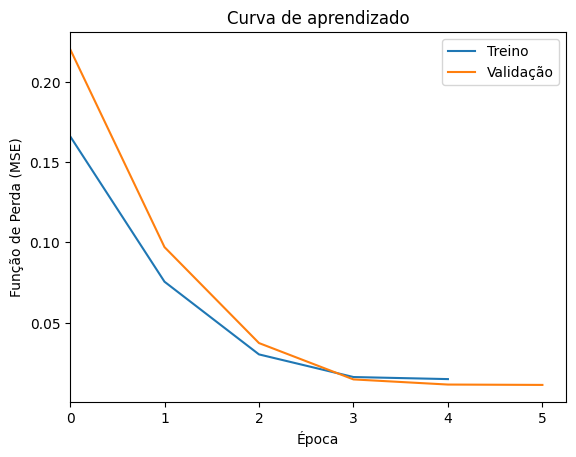

In [18]:
figura, eixo = plt.subplots()

ca_treino = minha_mlp.curva_aprendizado_treino
ca_val = minha_mlp.curva_aprendizado_val

eixo.plot(ca_treino, label="Treino")
eixo.plot(ca_val, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Função de Perda (MSE)")

<p style="text-align: justify;"> O gráfico acima representa a curva de aprendizado de nossa rede neural com o passar das épocas, isso é calculado com base na variação do "Loss". Loss refere-se a uma medida que indica o quão bem o modelo está performando em uma tarefa específica. O objetivo principal é minimizar essa perda durante o treinamento da rede. A perda é uma função que calcula a diferença entre a saída prevista pelo modelo e o valor real esperado, e é isso que podemos ver no gráfico acima. Abaixo colocamos nossa rede neural no modo de avaliação

In [19]:
minha_mlp.eval()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

<p style="text-align: justify;"> Escolhemo o erro quadrático médio como métrica para o modelo. Abaixo iniciamo o cáluculo de RMSE desabilitando o cálculo dos gradiente, uma atitude ideal quando estamos tratando do cálculo de avalicações de modelos, após isso fazemos a inferência do modelo.

In [20]:
dm.setup("test")

with torch.no_grad():
    X_true = dm.X_teste

    y_true = dm.y_teste
    y_true = dm.y_scaler.inverse_transform(y_true)

    y_pred = minha_mlp(X_true)
    y_pred = dm.y_scaler.inverse_transform(y_pred)

    RMSE = root_mean_squared_error(y_true, y_pred)

    print(RMSE)

268.6082914972533


In [21]:
pd.read_pickle('../Conjuntos de dados/Dataset.pickle')

,Su,Sy,E,G,mu,Ro
0,421,314,207000,79000,0.3,7860
1,424,324,207000,79000,0.3,7860
2,386,284,207000,79000,0.3,7860
3,448,331,207000,79000,0.3,7860
4,441,346,207000,79000,0.3,7860
...,...,...,...,...,...,...
1539,600,370,169000,70000,0.2,7160
1540,700,420,169000,70000,0.2,7160
1541,800,480,169000,70000,0.2,7160
1542,400,180,160000,64000,0.27,7160


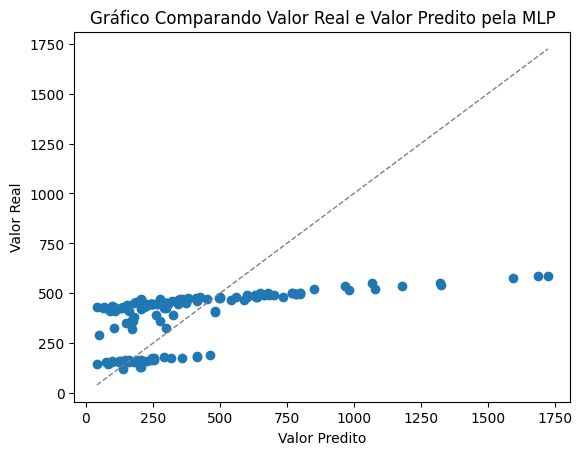

In [22]:
plt.scatter(y_true.ravel(),y_pred.ravel())
plt.title("Gráfico Comparando Valor Real e Valor Predito pela MLP")
plt.ylabel("Valor Real")
plt.xlabel("Valor Predito")
_ = plt.plot([min(y_true.ravel()), max(y_true.ravel())], [min(y_true.ravel()), max(y_true.ravel())],color = 'gray',linestyle = '--',linewidth = 1)

<p style="text-align: justify;"> O gráfico acima representa os valores reais de nosso conjunto de dados em comparação com os valores preditos por nossa rede neural. Quanto mais linear for esse gráfico, melhor desempenho nosso modelo está tendo.

Referências:

[1] Cassar, D. R. ATP-303 NN 5.2 - Notebook PyTorch.